In [25]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import os # need for file enumeration
import random
from sklearn.model_selection import train_test_split


# CNN

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,LeakyReLU

# pre-trained
from tensorflow.keras.applications import VGG19,EfficientNetB4

# garbage collector to clean memory after modeling
import gc

# reloads module to update
import universal_methods
import importlib
importlib.reload(universal_methods)
# .py file with universal methods, that I use more than one time in this project
from universal_methods import Universal

# For reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

## Data Acquisition

In [9]:
X,y,class_labels=Universal().get_images()
class_labels

Found 2041 images belonging to 2 classes.


['fake', 'real']

General class proportions

<Figure size 432x288 with 0 Axes>

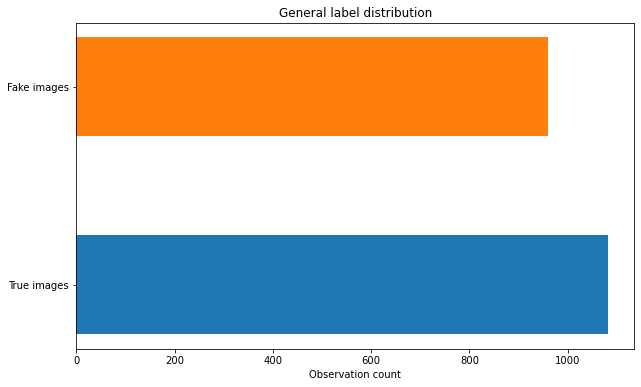

In [19]:
Universal().plot_proportions(y,"General label distribution")

Dataset contains two balanced classes. With almost equal amount of fakes and real images.

___
##### Train-val-test split
Split and shapes check. Did X_train split twice to get validation set.

In [11]:
X_train_temp,X_test,y_train_temp,y_test=train_test_split(X,y,random_state=42,stratify=y,test_size=0.1)
X_train,X_val,y_train,y_val=train_test_split(X_train_temp,y_train_temp,random_state=42,stratify=y_train_temp,test_size=0.11)
X_train.shape,y_train.shape,X_val.shape,y_val.shape, X_test.shape,y_test.shape

((1634, 600, 600, 3),
 (1634,),
 (202, 600, 600, 3),
 (202,),
 (205, 600, 600, 3),
 (205,))

Plot of class proportion for X_train

In [3]:
202/2041

0.09897109260166585

<Figure size 432x288 with 0 Axes>

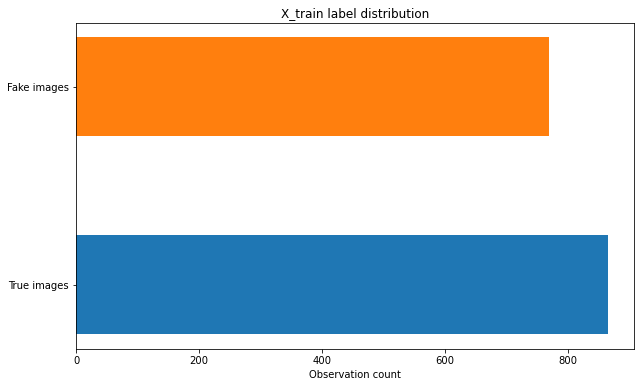

In [20]:
Universal().plot_proportions(y_train,"X_train label distribution")

Plot of class proportion for X_val

<Figure size 432x288 with 0 Axes>

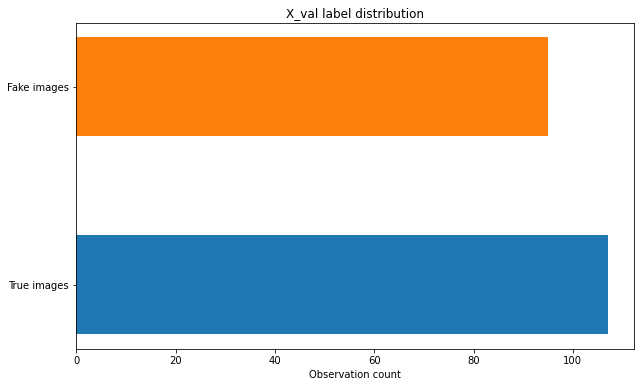

In [21]:
Universal().plot_proportions(y_val,"X_val label distribution")

Plot of class proportion for X_test

<Figure size 432x288 with 0 Axes>

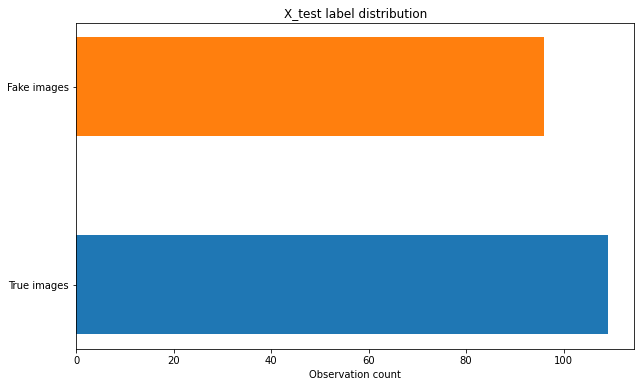

In [22]:
Universal().plot_proportions(y_test,"X_test label distribution")

Baseline accuracy

In [8]:
print (f"Baseline accuracy : {(y>0).mean(0)}")

Baseline accuracy : 0.5296423321901029


## Modeling
----
##### Simple model 
First of all let's try to run our data through simple CNN.

In [23]:
# very simple CNN
model_simple = Sequential()
model_simple.add(Conv2D(filters = 8, kernel_size = (8, 8), activation = 'relu', input_shape = (600, 600, 3)))
model_simple.add(MaxPooling2D(pool_size = (3, 3)))
model_simple.add(Conv2D(filters = 8, kernel_size = (6, 6), activation = 'relu'))
model_simple.add(MaxPooling2D(pool_size = (2, 2)))
model_simple.add(Flatten())
model_simple.add(Dense(64, activation = 'relu'))
model_simple.add(Dense(1, activation = 'sigmoid'))
model_simple.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['acc'])
history_model_simple = model_simple.fit(
    X_train, y_train,
     batch_size = 32,
      epochs = 20,
       verbose = 1,
        validation_data = (X_val, y_val)
    )

Epoch 1/20


2022-11-13 16:39:50.431941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - ETA: 0s - loss: 0.6929 - acc: 0.5269

2022-11-13 16:40:09.892203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


52/52 [==============================] - 22s 383ms/step - loss: 0.6929 - acc: 0.5269 - val_loss: 0.6958 - val_acc: 0.5297
Epoch 2/20
52/52 [==============================] - 20s 378ms/step - loss: 0.6925 - acc: 0.5294 - val_loss: 0.6959 - val_acc: 0.5297
Epoch 3/20
52/52 [==============================] - 18s 339ms/step - loss: 0.6922 - acc: 0.5294 - val_loss: 0.6962 - val_acc: 0.5297
Epoch 4/20
52/52 [==============================] - 17s 329ms/step - loss: 0.6920 - acc: 0.5294 - val_loss: 0.6964 - val_acc: 0.5297
Epoch 5/20
52/52 [==============================] - 17s 330ms/step - loss: 0.6919 - acc: 0.5294 - val_loss: 0.6966 - val_acc: 0.5297
Epoch 6/20
52/52 [==============================] - 20s 384ms/step - loss: 0.6917 - acc: 0.5294 - val_loss: 0.6969 - val_acc: 0.5297
Epoch 7/20
52/52 [==============================] - 17s 334ms/step - loss: 0.6916 - acc: 0.5294 - val_loss: 0.6971 - val_acc: 0.5297
Epoch 8/20
52/52 [==============================] - 17s 326ms/step - loss: 0.691

In [24]:
model_simple.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 593, 593, 8)       1544      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 197, 197, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 8)       2312      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 96, 96, 8)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 64)               

And generate summary plot.

2022-11-13 16:45:44.020339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 147ms/step


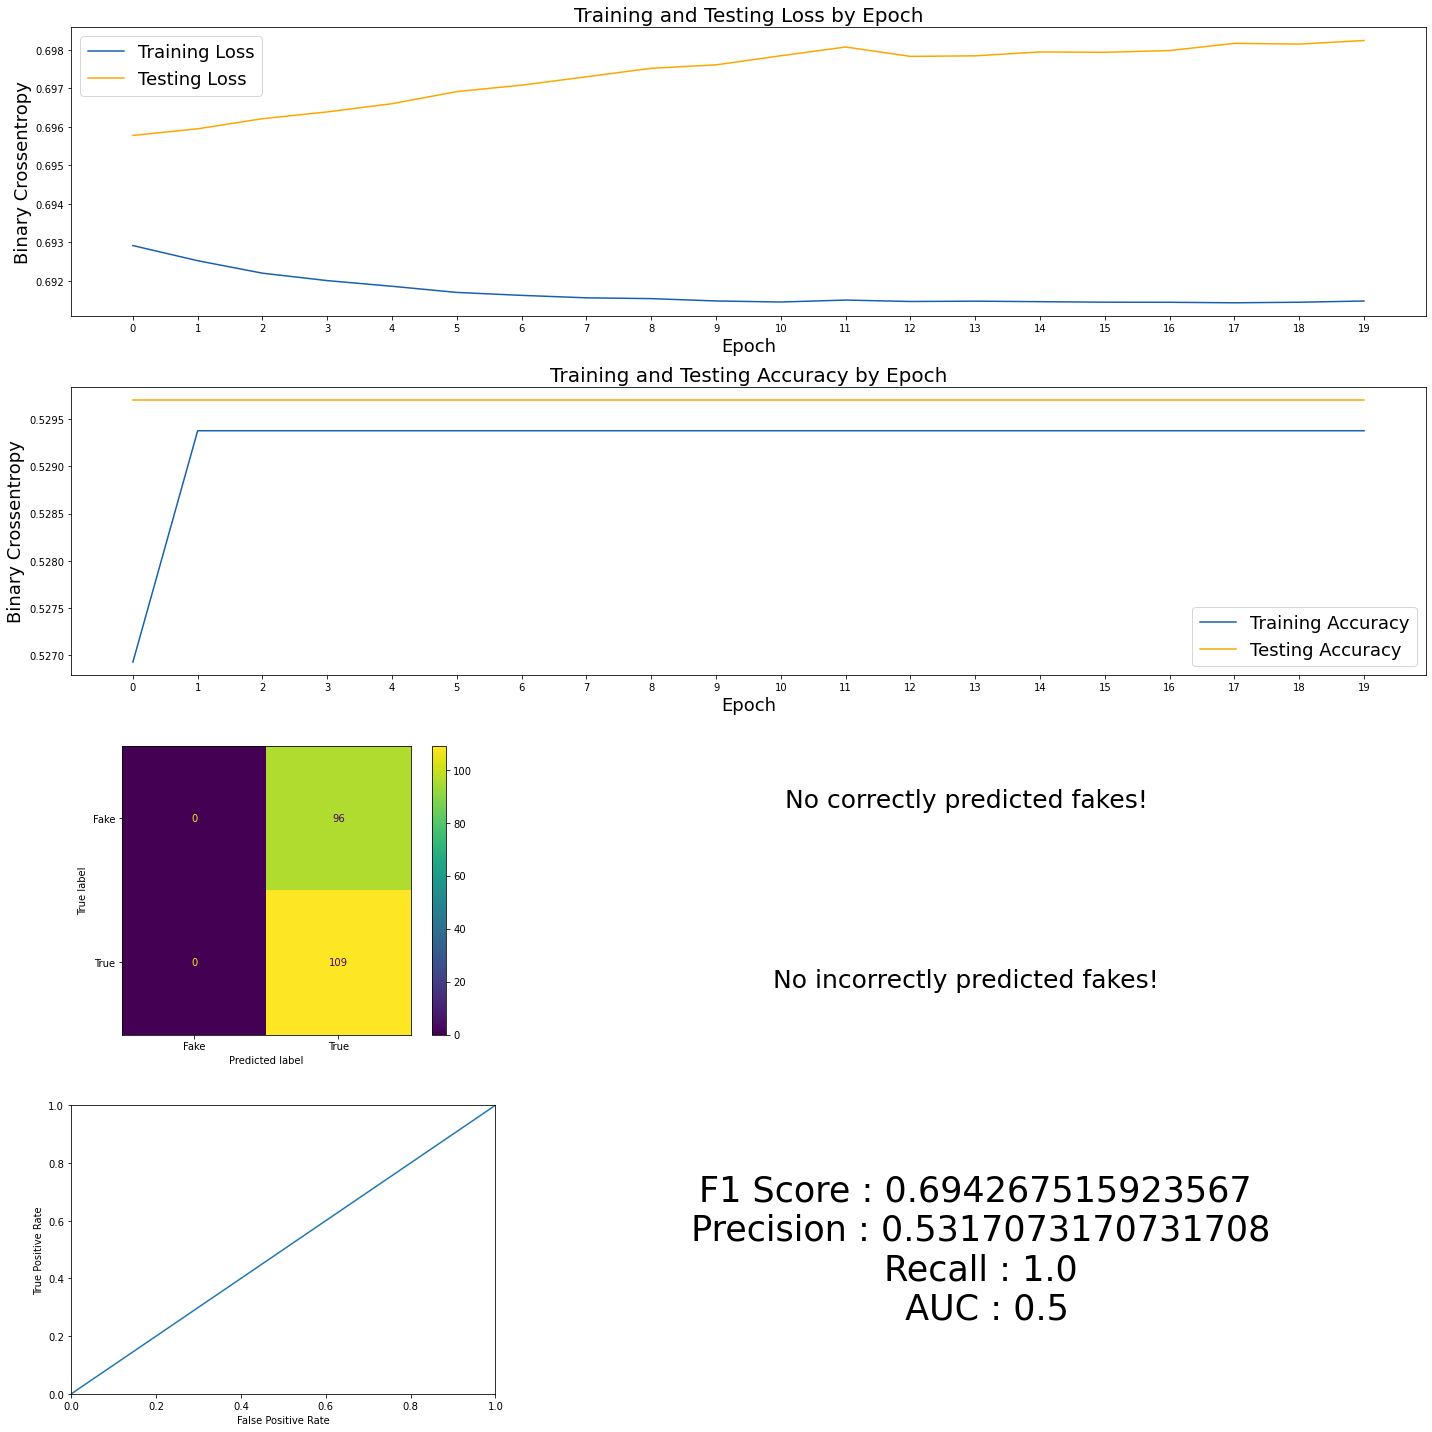

In [25]:
# Method I've developed to visualize all crucial modeling results on one plot. 
matches,mismatches,mismatches_real=Universal().plot_results_duo(history_model_simple,model_simple,X_test,y_test,"02/model_simple");

Confusion matrix shows that model can't effectively catch the signal to correctly recognize and predict fakes. 
X_test set totally contains 205 images, and model predicted that all of them are true/real images.   

ROC-AUC plot shows that true and false image sets are not just overlapping - for the model they are basically identically and it clearly doesn't learn as it should. This can be caused either by simplicity of the model, either by images which need more manipulation/augmentation to highlight their differences. For now it is not clear, why model doesn't work as it suppose.
 To exclude model assumption, let's pass our dataset through much more powerful pre-trained model. 

Quick check of layer's output, using this image as an example.

(<matplotlib.image.AxesImage at 0x150021eb0>, 1.0)

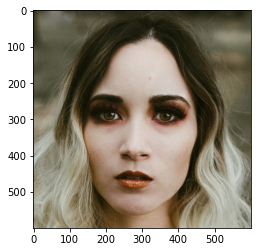

In [26]:
plt.imshow(X_test[6]),y_test[6]

First of all, let's check Grad-Cam to see which parts of the image, model used more to make a prediction. 
It's a simple model, so basically we can say it captured border between different contrast zones.


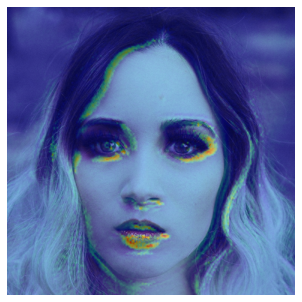

In [31]:
Universal().get_conv(model_simple,X_test[6],"02/model_simple_grad",alpha=0.4);

Next, I'll plot stages of image transformation  from layer to layer inside the model. We probably won't get much use out of this and this is one of the reasons, why neural networks are considered as "black boxed". But it is really good for basic understanding of how exactly convolutional layers work.

1/1 [==============================] - 0s 34ms/step


2022-11-13 16:54:22.538348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

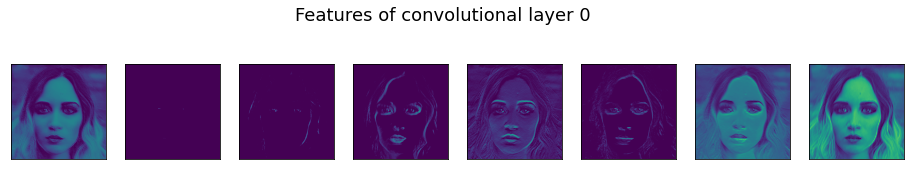

In [39]:
Universal().get_feat(model_simple,X_test[6],layer_num=0,savename="02/model_simple_features_conv_0");

1/1 [==============================] - 0s 83ms/step


2022-11-13 16:54:33.740001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

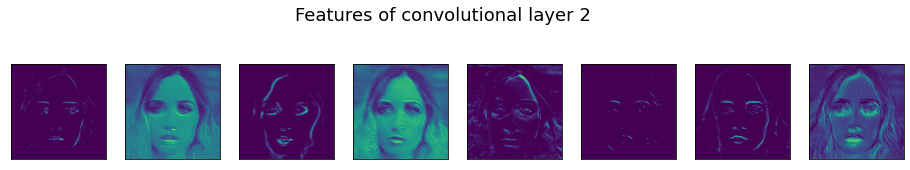

In [40]:
Universal().get_feat(model_simple,X_test[6],layer_num=2,savename="02/model_simple_features_conv_2");

These plots show how model's convolution layer sees images and what actual part of images are used for training



---
Filters

This is filter set for the first Conv layer. Each column represent filters for each color channel.
The dark squares indicate small weights, light squares represent large weights. Filters are in the size 8x8 pix, whicch is our kernel size on the Conv layer.

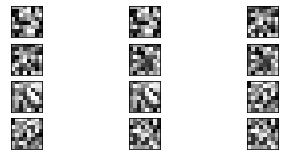

In [42]:
Universal().get_filters(model_simple,0,savename="02/model_simple_filters_conv_0")

Cleaning

In [17]:
# free-up memory
del model_simple
gc.collect()
tf.keras.backend.clear_session()

----

##### Pre-trained model

Now let's try our dataset on a much more complicated model with prelearned weights.

In [43]:
pretrained_vgg = VGG19(input_shape=[600,600,3], include_top=False,weights="imagenet")
pretrained_vgg.trainable = False;

In [44]:
model_vgg=Sequential()
model_vgg.add(pretrained_vgg)
model_vgg.add(Flatten())

model_vgg.add(Dense(128,activation="relu"))
model_vgg.add(Dense(64,activation="relu"))
model_vgg.add(Dense(1,activation="sigmoid"))
model_vgg.compile(loss="binary_crossentropy",optimizer='adam',metrics=['acc'])
history_vgg=model_vgg.fit(X_train,y_train,batch_size=16,validation_data=(X_val,y_val),epochs=10,verbose=1)


Epoch 1/10


2022-11-13 16:55:56.099857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 0.9934 - acc: 0.5049

2022-11-13 16:58:04.059869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 145s 1s/step - loss: 0.9934 - acc: 0.5049 - val_loss: 1.0153 - val_acc: 0.4703
Epoch 2/10
103/103 [==============================] - 138s 1s/step - loss: 0.7243 - acc: 0.5220 - val_loss: 0.6990 - val_acc: 0.4802
Epoch 3/10
103/103 [==============================] - 137s 1s/step - loss: 0.7339 - acc: 0.5171 - val_loss: 0.8377 - val_acc: 0.4703
Epoch 4/10
103/103 [==============================] - 137s 1s/step - loss: 0.7038 - acc: 0.5049 - val_loss: 0.6922 - val_acc: 0.5248
Epoch 5/10
103/103 [==============================] - 141s 1s/step - loss: 0.6990 - acc: 0.5024 - val_loss: 0.6957 - val_acc: 0.5297
Epoch 6/10
103/103 [==============================] - 604s 6s/step - loss: 0.6976 - acc: 0.5086 - val_loss: 0.8524 - val_acc: 0.5297
Epoch 7/10
103/103 [==============================] - 137s 1s/step - loss: 0.6988 - acc: 0.5098 - val_loss: 0.7003 - val_acc: 0.3713
Epoch 8/10
103/103 [==============================] - 137s 1s/step - loss: 0.692

In [45]:
model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 18, 18, 512)       20024384  
                                                                 
 flatten_2 (Flatten)         (None, 165888)            0         
                                                                 
 dense_5 (Dense)             (None, 128)               21233792  
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 41,266,497
Trainable params: 21,242,113
Non-trainable params: 20,024,384
_________________________________________________________________


Generating summary

2022-11-13 17:29:01.791259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 18s 3s/step


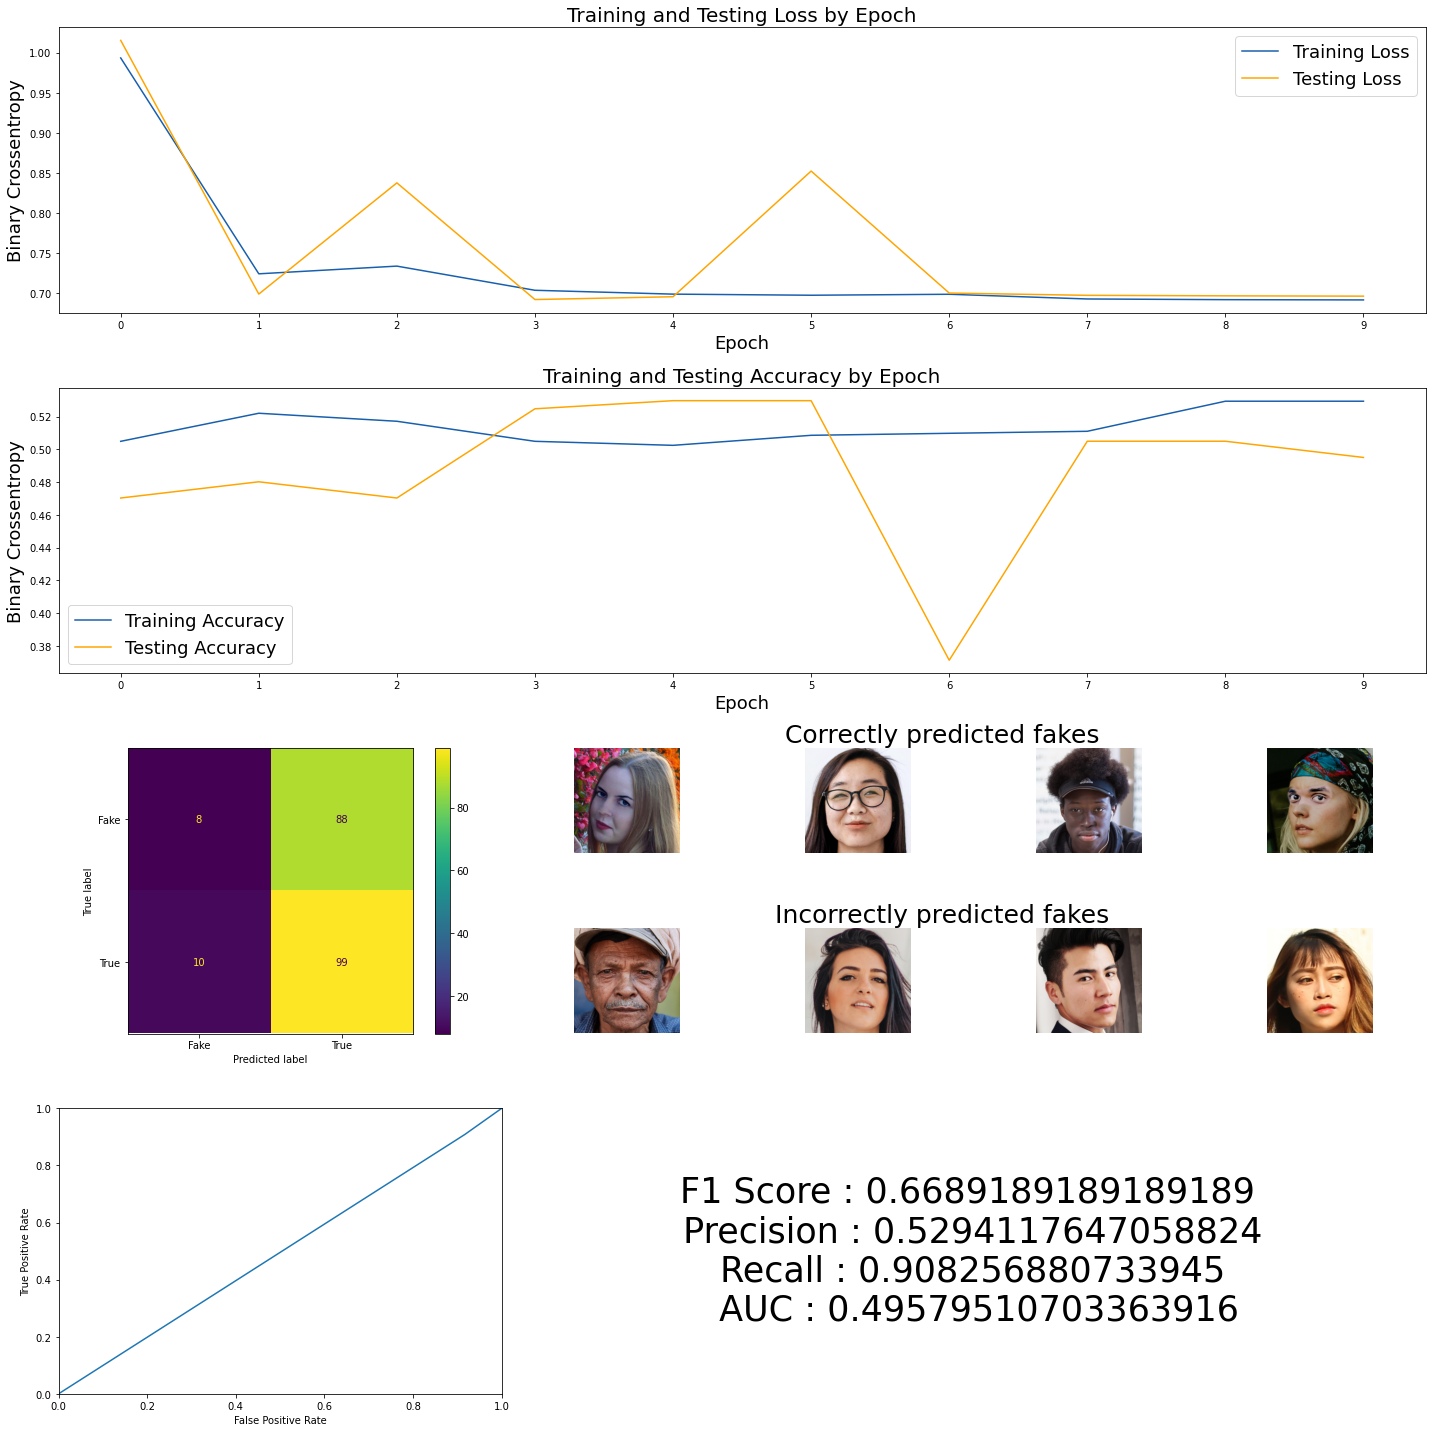

In [46]:
matches_2,mismatches_2, plot=Universal().plot_results_duo(history_vgg,model_vgg,X_test,y_test,"02/VGG");

Summary shows, that results of modeling are really close to the simple model. Despite, VGG is trying to catch some signal, it is not able to recognize difference between two classes. Performance of the model is lower than baseline accuracy.

Cleaning

In [ ]:
# free-up memory
del model_vgg
gc.collect()
tf.keras.backend.clear_session()

----
##### Pretrained model 2

As second pre-trained model, I'll use EfficientNetB4, it was used by a lot of Kaggle and Facebook competition winners. It has input size 380x380 so I'll re-generate dataset in that size, using parameter.

In [2]:
X_380,y_380,class_labels=Universal().get_images(size=380)
class_labels

Found 2041 images belonging to 2 classes.


['fake', 'real']

Creating new X_train, X_val, X_test sets at 380x380 size.

In [3]:
X_train_temp_380,X_test_380,y_train_temp_380,y_test_380=train_test_split(X_380,y_380,random_state=42,stratify=y_380,test_size=0.1)
X_train_380,X_val_380,y_train_380,y_val_380=train_test_split(X_train_temp_380,y_train_temp_380,random_state=42,stratify=y_train_temp_380,test_size=0.11)
X_train_380.shape,y_train_380.shape,X_val_380.shape,y_val_380.shape, X_test_380.shape,y_test_380.shape

((1634, 380, 380, 3),
 (1634,),
 (202, 380, 380, 3),
 (202,),
 (205, 380, 380, 3),
 (205,))

Creating an instance of a EfficientNetB4 model.

In [4]:
eff_net = EfficientNetB4(include_top=False, weights='imagenet',input_shape=(380,380,3))
eff_net.trainable=False

2022-11-13 17:32:41.441228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-13 17:32:41.442261: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



And fitting the dataset

In [5]:
model_eff=Sequential()
model_eff.add(eff_net)
model_eff.add(Flatten())
model_eff.add(Dense(128,activation="relu"))
model_eff.add(Dense(64,activation="relu"))
model_eff.add(Dense(1,activation="sigmoid"))
model_eff.compile(loss="binary_crossentropy",optimizer='adam',metrics=['acc'])
history_model_eff=model_eff.fit(X_train_380,y_train_380,batch_size=16,validation_data=(X_val_380,y_val_380),epochs=10,verbose=1)


Epoch 1/10


2022-11-13 17:32:51.609052: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-13 17:32:57.517353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 3.7917 - acc: 0.5171

2022-11-13 17:33:57.153263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 75s 645ms/step - loss: 3.7917 - acc: 0.5171 - val_loss: 8.0016 - val_acc: 0.5297
Epoch 2/10
103/103 [==============================] - 59s 573ms/step - loss: 2.1815 - acc: 0.5080 - val_loss: 0.7581 - val_acc: 0.4703
Epoch 3/10
103/103 [==============================] - 58s 561ms/step - loss: 0.9615 - acc: 0.5055 - val_loss: 1.1703 - val_acc: 0.5297
Epoch 4/10
103/103 [==============================] - 58s 563ms/step - loss: 0.8514 - acc: 0.4994 - val_loss: 0.8847 - val_acc: 0.4703
Epoch 5/10
103/103 [==============================] - 59s 568ms/step - loss: 0.7866 - acc: 0.5263 - val_loss: 0.6924 - val_acc: 0.4802
Epoch 6/10
103/103 [==============================] - 59s 568ms/step - loss: 0.9279 - acc: 0.4878 - val_loss: 0.7155 - val_acc: 0.5297
Epoch 7/10
103/103 [==============================] - 57s 556ms/step - loss: 0.7794 - acc: 0.5086 - val_loss: 1.3237 - val_acc: 0.5297
Epoch 8/10
103/103 [==============================] - 56s 545ms/st

In [7]:
model_eff.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 12, 12, 1792)     17673823  
                                                                 
 flatten (Flatten)           (None, 258048)            0         
                                                                 
 dense (Dense)               (None, 128)               33030272  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 50,712,416
Trainable params: 33,038,593
Non-trainable params: 17,673,823
_________________________________________________________________


2022-11-13 17:43:06.850874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 15s 1s/step


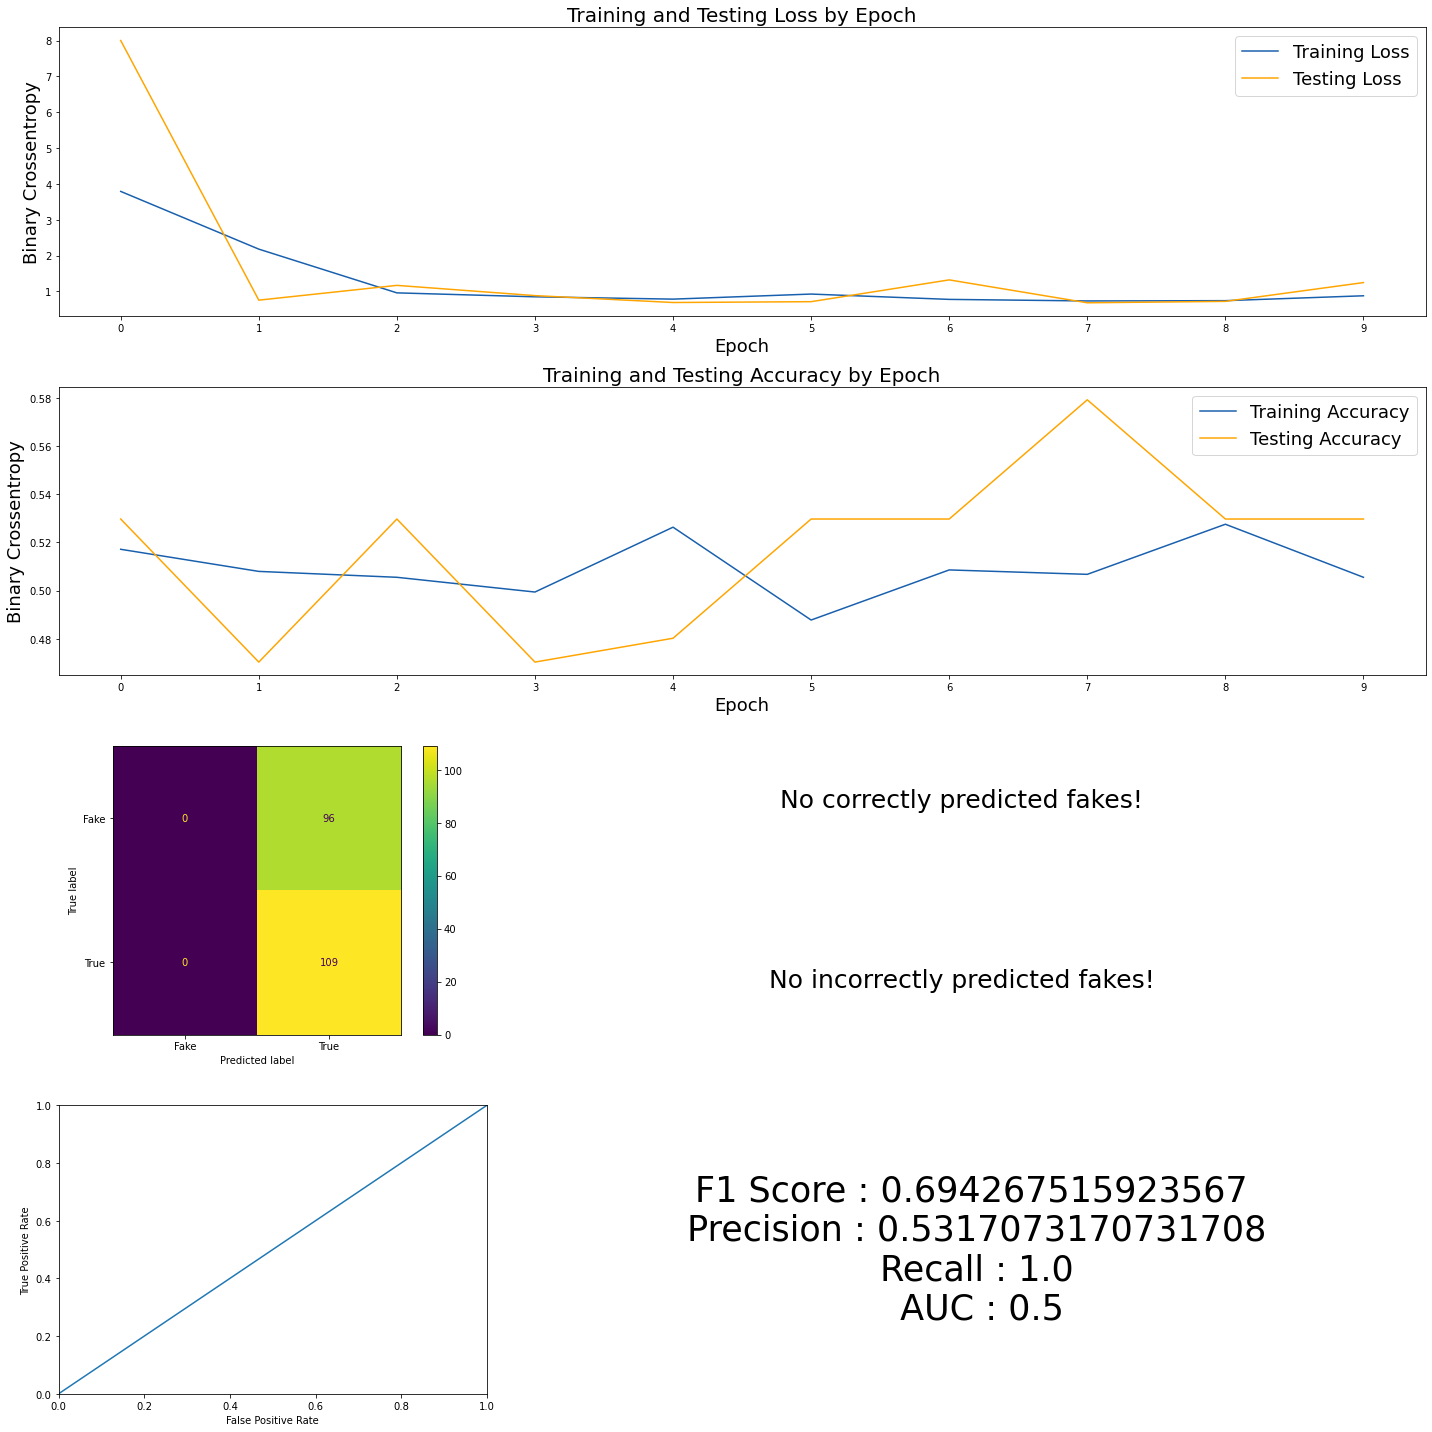

In [6]:
matches_3,mismatches_3, plot=Universal().plot_results_duo(history_model_eff,model_eff,X_test_380,y_test_380,"02/EfficientNetB4");

Still no good results, but we can see on accuracy subplot that model started learning, and model ran much faster because of the smaller dataset size. Although it is close to vgg performance, I'd say, we have some improvements.

Cleaning

In [ ]:
# free-up memory
del model_eff
gc.collect()
tf.keras.backend.clear_session()

----
##### Custom Model
https://github.com/nii-yamagishilab/MesoNet#

So, my next attempt will be custom model with a much smaller input images size. That will increase iteration speed and will let me to manually adjust layers.
<p> First of all, I'll generate dataset.

In [2]:
X_150,y_150,class_labels=Universal().get_images(size=150)
class_labels

Found 2041 images belonging to 2 classes.


['fake', 'real']

Train-val-test split

In [3]:
X_train_temp_150,X_test_150,y_train_temp_150,y_test_150=train_test_split(X_150,y_150,random_state=42,stratify=y_150,test_size=0.1)
X_train_150,X_val_150,y_train_150,y_val_150=train_test_split(X_train_temp_150,y_train_temp_150,random_state=42,stratify=y_train_temp_150,test_size=0.11)
X_train_150.shape,y_train_150.shape,X_val_150.shape,y_val_150.shape, X_test_150.shape,y_test_150.shape

((1634, 150, 150, 3),
 (1634,),
 (202, 150, 150, 3),
 (202,),
 (205, 150, 150, 3),
 (205,))

Building a model

In [10]:
model_custom=Sequential()
model_custom.add(Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation = 'relu',use_bias=True,input_shape = (150, 150, 3)))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_custom.add(Conv2D(8, (5, 5), padding='same', activation = 'relu',use_bias=True))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_custom.add(Conv2D(16, (5, 5), padding='same', activation = 'relu',use_bias=True))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model_custom.add(Conv2D(16, (5, 5), padding='same', activation = 'relu',use_bias=True))
model_custom.add(BatchNormalization())
model_custom.add(MaxPooling2D(pool_size=(4, 4), padding='same'))
model_custom.add(Flatten())
model_custom.add(Dropout(0.5))
model_custom.add(Dense(16,kernel_regularizer =tf.keras.regularizers.l2(l=0.005)))
model_custom.add(LeakyReLU(alpha=0.1))
model_custom.add(Dropout(0.5))
model_custom.add(Dense(1, activation = 'sigmoid'))
model_custom.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
history_custom=model_custom.fit(X_train_150, y_train_150, batch_size = 128, epochs = 25, verbose = 1, validation_data = (X_val_150, y_val_150))


Epoch 1/25


2022-11-13 17:47:59.477899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 1.4591 - acc: 0.4798

2022-11-13 17:48:01.409753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 3s 131ms/step - loss: 1.4591 - acc: 0.4798 - val_loss: 0.8441 - val_acc: 0.4901
Epoch 2/25
13/13 [==============================] - 1s 74ms/step - loss: 0.9773 - acc: 0.5208 - val_loss: 0.8373 - val_acc: 0.5495
Epoch 3/25
13/13 [==============================] - 1s 71ms/step - loss: 0.9398 - acc: 0.5159 - val_loss: 0.8242 - val_acc: 0.5842
Epoch 4/25
13/13 [==============================] - 1s 73ms/step - loss: 0.9125 - acc: 0.5220 - val_loss: 0.8190 - val_acc: 0.5446
Epoch 5/25
13/13 [==============================] - 1s 69ms/step - loss: 0.8703 - acc: 0.5649 - val_loss: 0.8171 - val_acc: 0.5743
Epoch 6/25
13/13 [==============================] - 1s 69ms/step - loss: 0.8797 - acc: 0.5361 - val_loss: 0.8243 - val_acc: 0.5594
Epoch 7/25
13/13 [==============================] - 1s 73ms/step - loss: 0.8749 - acc: 0.5441 - val_loss: 0.8428 - val_acc: 0.5347
Epoch 8/25
13/13 [==============================] - 1s 70ms/step - loss: 0.8604 - acc: 0.5294

Generating model summary

In [7]:
model_custom.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 8)       224       
                                                                 
 batch_normalization_4 (Batc  (None, 150, 150, 8)      32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 8)         1608      
                                                                 
 batch_normalization_5 (Batc  (None, 75, 75, 8)        32        
 hNormalization)                                                 
                                                      

7/7 [==============================] - 0s 19ms/step


2022-11-13 17:48:27.757016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


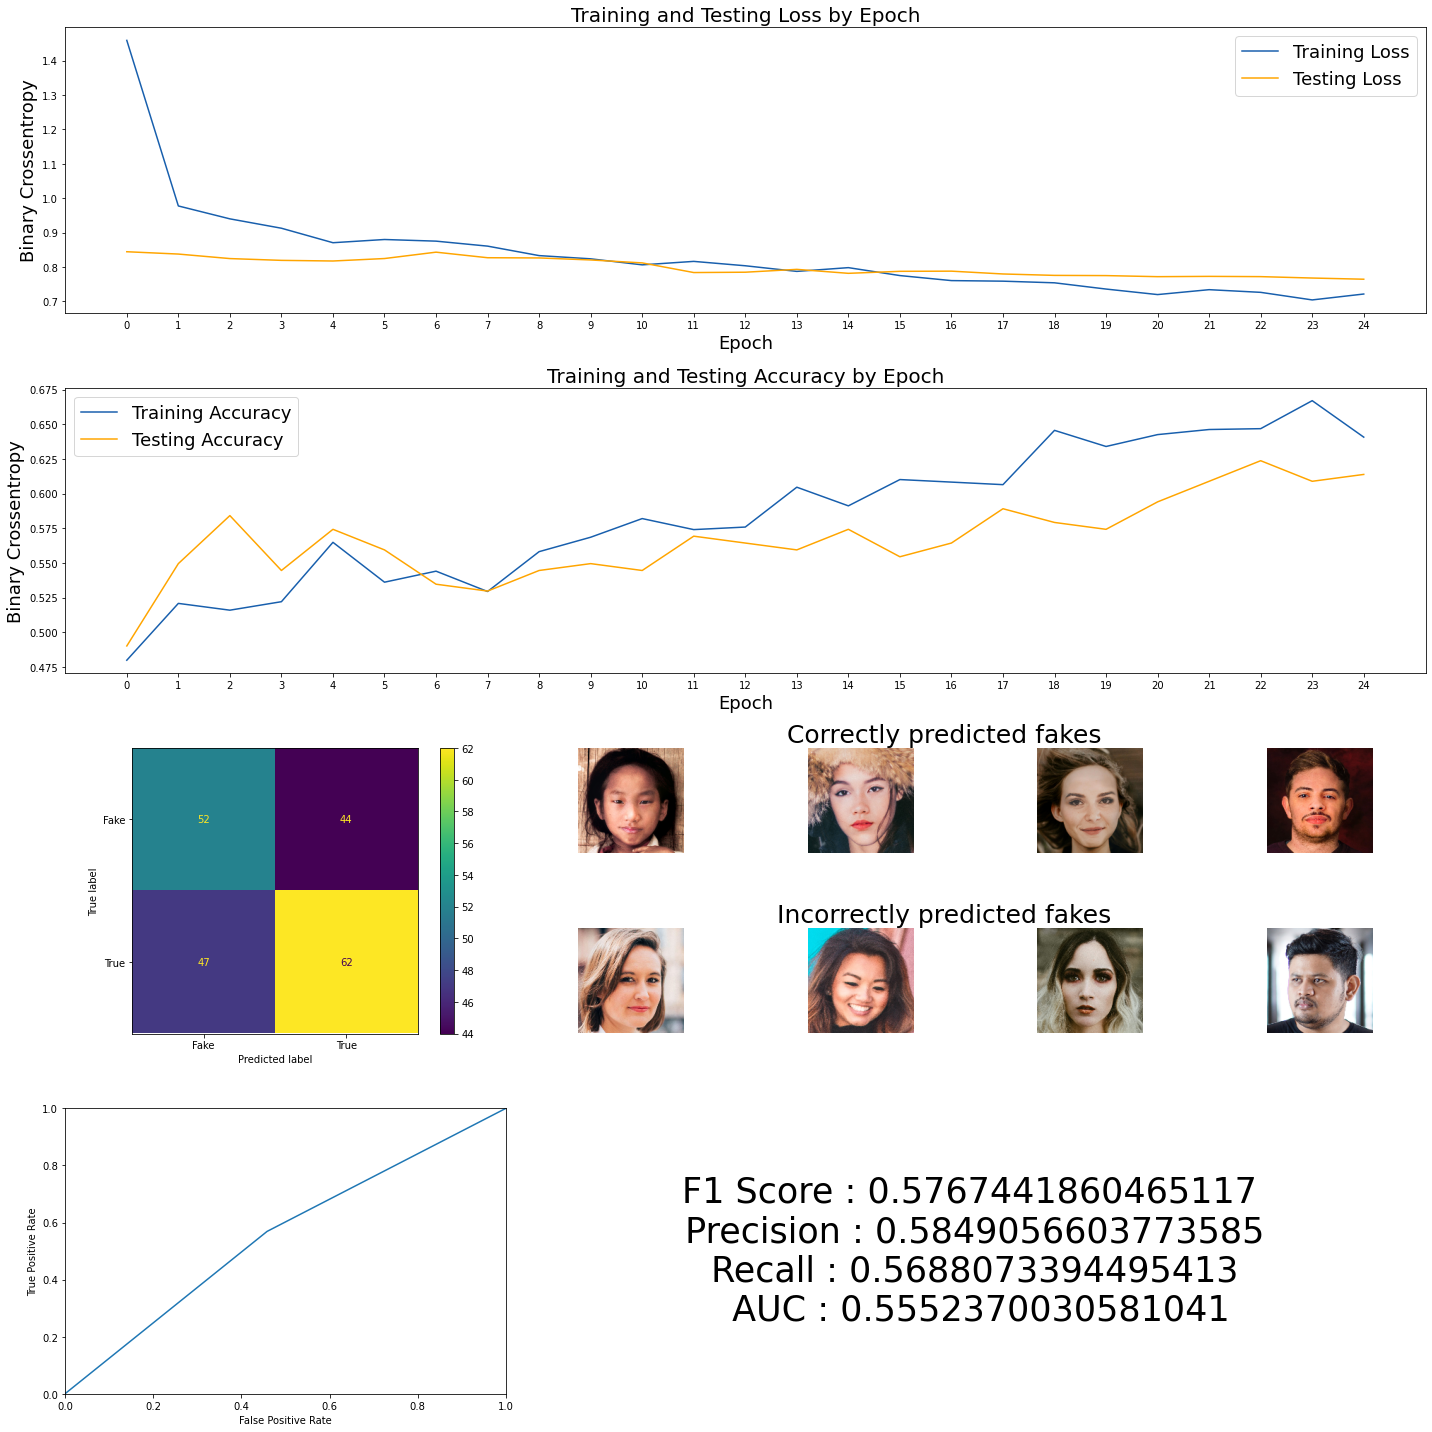

In [11]:
matches_4,mismatches_4,mismatches_real_4=Universal().plot_results_duo(history_custom,model_custom,X_test_150,y_test_150,"02/custom_model");

These are finally good results.
Model started to differentiate two classes and make correct predictions.
All scores are beyond baseline.

Although, due to AUC score, both classes are very similar/overlapped for the model, it definitely made some progress at differentiating them.

Let's take a more detailed look at matched and mismatched images.
___
First, let's plot images correctly predicted as fakes.

<Figure size 432x288 with 0 Axes>

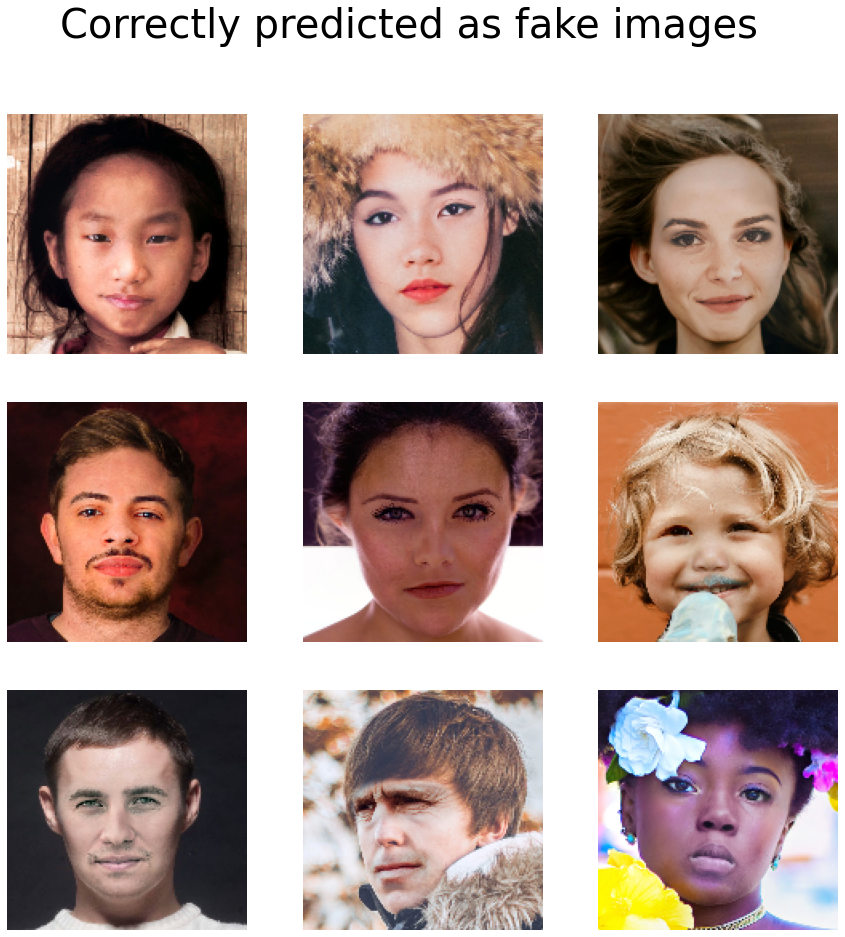

In [12]:
matches_custom=[X_test_150[x] for x in matches_4]
Universal().plot_samples(matches_custom,9,3,"Correctly predicted as fake","02/corr_pred_as_fake_custom_example");

It's hard to tell if there are any common feature. All types of fakes are presented (easy, mid and hard).
___
Let's take a look at mismatches then. These are fakes predicted as real images.

<Figure size 432x288 with 0 Axes>

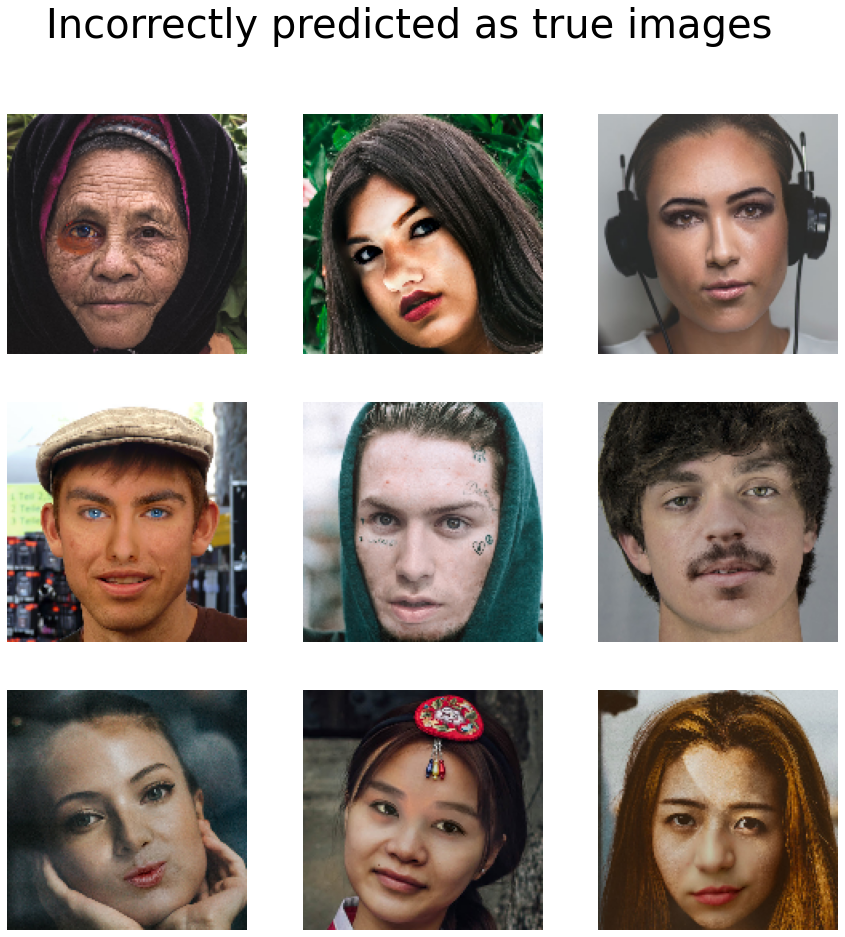

In [13]:
mismatches_custom=[X_test_150[x] for x in mismatches_real_4]
Universal().plot_samples(mismatches_custom,9,3,"Incorrectly predicted as true","02/incorr_pred_as_true_custom_example");

Similarly to matches, it's hard to highlight common feature for mismatches, fake types are mixed, so as color schemes, photo perspective, facetype due to sex, etc. Let's look at the hidden layers output of the incorrectly predicted fake image.

1/1 [==============================] - 0s 81ms/step


2022-11-13 17:50:39.603106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

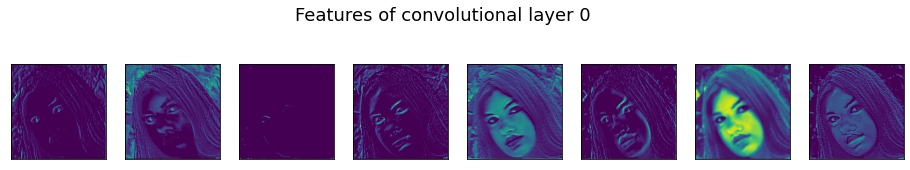

In [14]:
Universal().get_feat(model_custom,X_test_150[mismatches_real_4[1]],layer_num=0,savename="02/model_best_features_conv_0");

Each convolution layer trying to find good features in image and pass it to the next layer.

1/1 [==============================] - 0s 127ms/step


2022-11-13 17:50:47.126201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

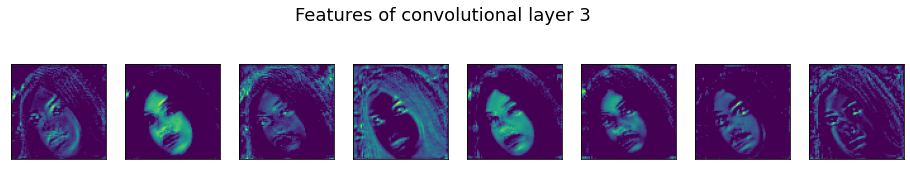

In [15]:
Universal().get_feat(model_custom,X_test_150[mismatches_real_4[1]],layer_num=3,savename="02/model_best_features_conv_3");

1/1 [==============================] - 0s 126ms/step


2022-11-13 17:51:01.773656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

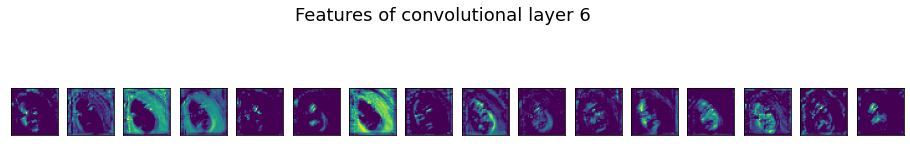

In [18]:
Universal().get_feat(model_custom,X_test_150[mismatches_real_4[1]],layer_num=6,savename="02/model_best_features_conv_6");

As image passes from layer to layer it changes due to max_pooling and feature extraction. The more layers the model has, 
the more output image will be changed.

1/1 [==============================] - 0s 38ms/step


2022-11-13 17:51:18.539880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

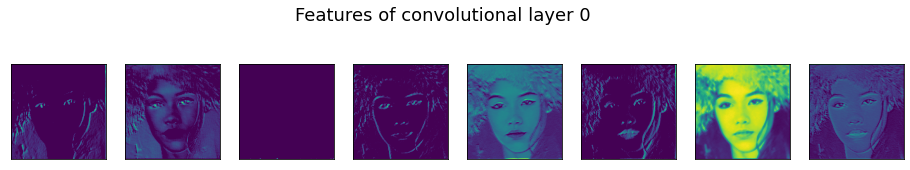

In [19]:
Universal().get_feat(model_custom,X_test_150[matches_4[1]],0,savename="02/model_best_features_conv_0_mismatch");

1/1 [==============================] - 0s 114ms/step


2022-11-13 17:51:24.841456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

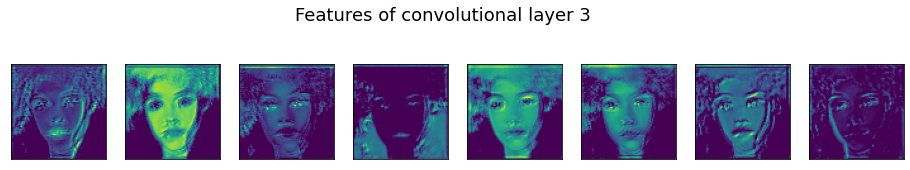

In [20]:
Universal().get_feat(model_custom,X_test_150[matches_4[1]],3,savename="02/model_best_features_conv_3_mismatch");

1/1 [==============================] - 0s 158ms/step


2022-11-13 17:51:29.917369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

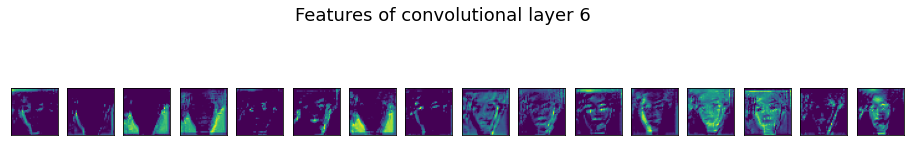

In [21]:
Universal().get_feat(model_custom,X_test_150[matches_4[1]],6,savename="02/model_best_features_conv_6_mismatch");

1/1 [==============================] - 0s 184ms/step


2022-11-13 17:51:34.854355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 432x288 with 0 Axes>

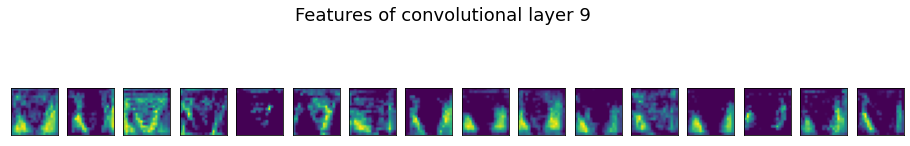

In [22]:
Universal().get_feat(model_custom,X_test_150[matches_4[1]],9,savename="02/model_best_features_conv_9_mismatch");

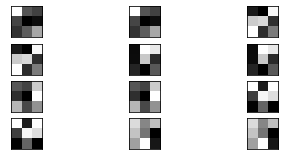

In [23]:
Universal().get_filters(model_custom,0,savename="02/best_model_filters")

 Incorrectly predicted fake image GRAD-CAM.

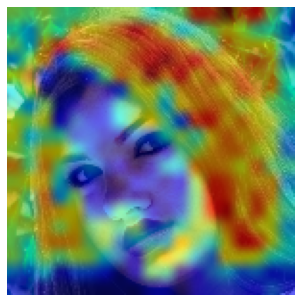

In [26]:
Universal().get_conv(model_custom,X_test_150[mismatches_real_4[1]],"02/model_custom_filters_mismatch");

Correctly predicted fake image GRAD-CAM.

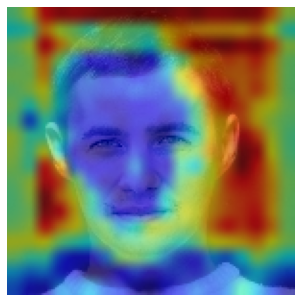

In [27]:

Universal().get_conv(model_custom,X_test_150[matches_4[6]],"02/model_custom_filters");


GradCam provides visual explanation on the modeling result. It graphically shows, which parts of the image were mostly used by the model to make predictions. For the first fake, model mostly used parts of image, that are not relevant to modified zone (which is at the nose area). 
And for the second, we can see correctly defined relevant zones located through facial contour. Which led to correct prediction.


Final cleaning

In [ ]:
# free-up memory
del model_custom
gc.collect()
tf.keras.backend.clear_session()

___
##### Intermediate conclusion
Finally, we have a robust result. Difference in scores between first three models and the last one shows, that change of input images positively affected model performance, in addition to much less time needed to process. I will use this last model as a production one. It gave me the best results,it really "catches the signal" and differences classes.
As a next step, I'll try to improve it's performance with augmentation technics and analyze results more deeply.